# Demonstration of the pdf evolution using MC method
First lets load the libraries which will be needed

In [1]:
from math import pi, sin, cos, sqrt, log, log10, exp
from ROOT import gRandom, gStyle, TCanvas, TH1D, TLorentzVector

Welcome to JupyROOT 6.12/07


Define function which returns 2D point according to the Gaussian distribution

In [2]:
def gauss2D(sigma):
    kT  = sigma * sqrt(-2*log(gRandom.Uniform()));
    phi = 2*pi * gRandom.Uniform()
    kx, ky = kT*cos(phi), kT*sin(phi)
    return (kx, ky)

Get PDF at the scale q2 (currently no dependece on q2)

In [3]:
Eb = 3500 # Beam energy
def getpdf(q2):
    xmin = 0.00001
    xmax = 0.999
    x = xmin * (xmax/xmin)**gRandom.Uniform()
    weightx = x*log(xmax/xmin) 
    # this is for the simple case            
    pdf = 3.*pow((1-x),5)/x

    kx, ky = gauss2D(0.7)
    pVec = TLorentzVector()
    pVec.SetXYZM(kx, ky, x*Eb, 0.)
    return pVec, weightx * pdf

Function to calculate the next scale in the evolution

In [4]:
def getNextScale(t0):
    #   here we calculate  from the sudakov form factor the next t > t0
    epsilon = 0.1
    as2pi = 0.1/(2.*pi)
    Ca = 3.
    # for Pgg use fact = 2*Ca
    fac = 2.*Ca 
    # use fixed alphas and only the 1/(1-z) term of the splitting fct

    r1 = gRandom.Uniform()
    Pint=log((1.-epsilon)/epsilon) # for 1/(1-z) splitting fct 
    t2 = -log(r1)/fac/as2pi/Pint
    t2 = t0 * exp(t2)
    assert(t2 >= t0)
    return t2

The splitting function which is needed to get the z on the branching point

In [5]:
def splitting():
    epsilon = 0.1
    #error ~ C / sqrt(Nevents)
    #z = epsilon + (1 - 2*epsilon) *Rand()
    #weightz = as2pi* 6 (1./z + 1./(1.-z))
    #return

    as2pi = 0.1/2./pi

    #		here we calculate  the splitting variable z for 1/z and  1/(1-z)
    #		use Pgg=6./z 
    # + 6./(1.-z))  // z -> 1-z

    g0 = 6.*as2pi * log((1.-epsilon)/epsilon)
    g1 = 6.*as2pi * log((1.-epsilon)/epsilon)
    gtot = g0 + g1 

    zmin = epsilon
    zmax = 1.-epsilon

    r1 = gRandom.Uniform()
    r2 = gRandom.Uniform()

    z = zmin * (zmax/zmin)**r2
    if r1 > g0/gtot:
        z = 1. - z
    weightz = 1.
    return z

Evolve the PDF between scales q20 and q2, the kinematics of the parton in the beggining is described by four-vector p0

In [6]:
def evolve_pdf(q20, q2, p0):
    x = p0.Pz()/Eb
    kx = p0.Px()
    ky = p0.Py()
    weightx = 1.
    t1 = q20
    tcut = q2
    while t1 < tcut:
        # here we do now the evolution
        # first we generate t
        t0 = t1
        t1 = getNextScale(t0) 
        # now we generate z
        z = splitting()
        #   since the sudakov involves only the 1/(1-z) part 
        #   of the splitting fct, we need to weight each branching
        #   by the ratio of the intgral of the full and 
        #   approximate splitting fct

        ratio_splitting = 2 # for using Pgg

        if  t1 < tcut:
            x = x*z
            weightx = weightx *ratio_splitting
            # 
            # use here the angular ordering condition: sqrt(t1) = qt/(1-z) 
            # and apply this also to the propagator gluons
            #
            phi = 2*pi*gRandom.Uniform()
            kx +=  sqrt(t1)*cos(phi)*(1.-z)
            ky +=  sqrt(t1)*sin(phi)*(1.-z)                     
            #   kx += sqrt(t1)*cos(phi)
            #   ky += sqrt(t1)*sin(phi)                     
    p1 = TLorentzVector()
    p1.SetXYZM(kx, ky, x*Eb, 0.)
    return p1, weightx

Book few histograms which will be needed

In [7]:
histo1  =  TH1D("x0","x0",100, -5, 0.)
histo2  =  TH1D("kt0 ","kt0 ",100, 0, 10.)
histo3  =  TH1D("x","x",100, -5, 0.)
histo4  =  TH1D("kt ","kt ",100, 0, 100.)

Do the evolution between scales q20 and q21 npoints times

In [8]:
q20 = 1
q21 = 100**2
npoints = 100000
for n1 in range(npoints):
    # generate starting distribution in x and kt
    p0, weight0 = getpdf(q20)
    # now do the evolution	
    p1, weight1 = evolve_pdf(q20, q21, p0)   
    weight = weight0 * weight1

    # weighting with 1/x0:
    # plot dxg(x)/dlogx *Jacobian, Jacobian dlogx/dx = 1/x
    # log(x) = 2.3026 log10(x)
    x   = p1.Pz()/Eb
    x0  = p0.Pz()/Eb
    #At the starting scale q20
    histo1.Fill(log10(x0), weight0)
    histo2.Fill(p0.Pt(), weight0)
    #At the final scale q2
    histo3.Fill(log10(x),  weight)
    histo4.Fill(p1.Pt(), weight)

Plot the x distribution in the starting scale and after the evolution

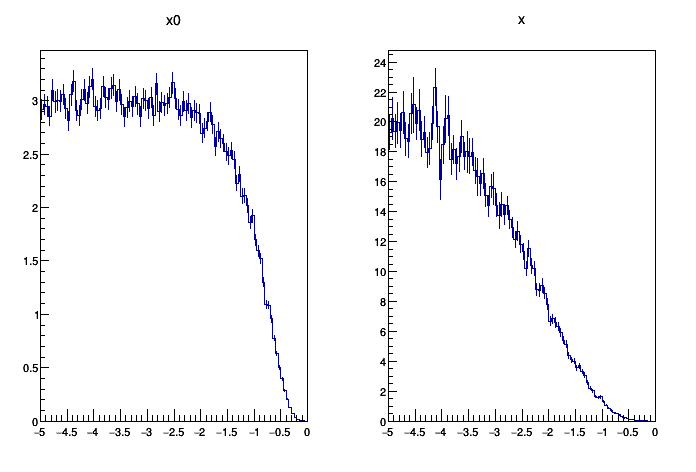

In [9]:
gStyle.SetOptStat(0) # get rid of statistics box
c = TCanvas();
c.Divide(2,1);
c.cd(1);
histo1.Scale(1./npoints/log(10), "width");
# gPad.SetLogy();
histo1.Draw("hist e");

c.cd(2);
histo3.Scale(1./npoints/log(10), "width");
c.SetLogy();
histo3.Draw("hist e");
c.Draw()

Plot the kT distribution in the starting scale and after the evolution

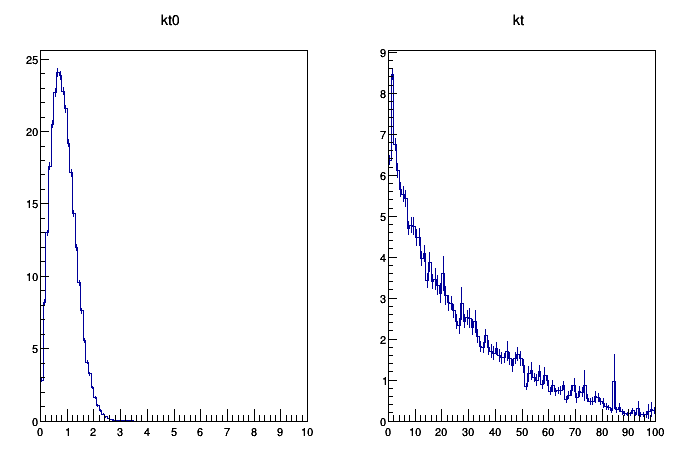

In [10]:
d = TCanvas();
d.Divide(2,1);
d.cd(1);
histo2.Scale(1./npoints, "width");
histo2.Draw("hist e");

d.cd(2);
histo4.Scale(1./npoints, "width");
d.SetLogy();
histo4.Draw("hist e");
d.Draw()